In [1]:
from datetime import datetime
from time import time
from itertools import combinations
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
global brands_list
global brand_followers
global condnsd_dist_mat
global dist_mat
global Z
global clusters

In [3]:
def check_data_file():
    import os.path
    if os.path.exists('brand_followers.tsv'):
        #fix brand followers - Do not run more than more
        out_file = open("brand_followers_fixed.tsv","w")
        with open('brand_followers.tsv','r') as data_file:
            data = data_file.read()
            data = data.replace('1114073faithhill','1114073\nfaithhill')
            out_file.write(data)
        out_file.close()
        os.remove('brand_followers.tsv')
        return True
    elif os.path.exists('brand_followers_fixed.tsv'):
        return True
    return False

In [4]:
def load_data(max_row_count=1404):
    global brands_list
    global brand_followers
    
    start = datetime.now()    
    
    brand_followers = {}
    brands_list = []
    
    row_id = 0
    with open('brand_followers_fixed.tsv') as data_file:
        for row in data_file:
            row_id += 1
            followers = row.split()
            brand = followers.pop(0)
            brand_followers[brand] = set([int(x) for x in followers])
            brands_list.append(brand)
            if row_id % 500 == 0:
                print( 'Loaded brand', row_id, '-', brand, 'with',len(followers),'followers.')
            if row_id == max_row_count:
                stop = datetime.now()
                print('Loaded',max_row_count,'rows in time',stop-start)
                break
    return

In [5]:
def create_distance_matrix():
    global brands_list
    global brand_followers
    global condnsd_dist_mat
    global dist_mat
    dist_mat = np.identity(len(brands_list))
    start = datetime.now()
    condnsd_dist_mat = []
    edges = 0
    for tuple_pair in combinations(enumerate(brands_list),2):
        b1 = brand_followers[tuple_pair[0][1]]
        b2 = brand_followers[tuple_pair[1][1]]
        #b1 = brand_followers[pair[0]]
        #b2 = brand_followers[pair[1]]
        
        #Jaccard Similarity Measure
        common_connections = len(b1.intersection(b2))
        total_connections = len(b1) + len(b2) - common_connections #More efficient than set(b1).union(b2)
        weight = common_connections/total_connections

        condnsd_dist_mat.append(1.0 - weight)
        dist_mat[tuple_pair[0][0] , tuple_pair[1][0]] = dist_mat[tuple_pair[1][0] , tuple_pair[0][0]] = 1.0 - weight
        
        edges += 1
        if edges%80000 == 0:
            print(edges, 'edges loaded.')
        
    stop = datetime.now()
    
    print('Created',len(brands_list),'x',len(brands_list),'Distance Matrix in time',stop-start)
    brand_followers = {}
    return

In [50]:
def create_clusters():
    global condnsd_dist_mat
    global brands_list
    global Z
    
    start = datetime.now()
    #clustering = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(distance_matrix)
    #print(clustering.labels_)
    #fig = plt.figure(figsize=(15,15))
    #i = 1
    for method in ['complete']: #['single', 'complete', 'average', 'weighted']:
        #method='single'
        print('Method',method)
        Z = sch.linkage(condnsd_dist_mat, method=method)
        #print(Z)
        get_clusters()
        plt.clf()
        fig = plt.figure(figsize=(150,150))
        
        dd = sch.dendrogram(Z, labels=brands_list,orientation='right')

        #plt.tight_layout()
        plt.savefig('figures/{}.pdf'.format(method))
        print('Elapsed time',datetime.now()-start)
        
    stop = datetime.now()
    print('Clustering completed in time',stop-start)

In [7]:
def get_clusters():
    global Z
    global clusters
    z = sch.fcluster(Z,0.99999999)
    clusters = {}
    for i in range(1,max(z)+1):
        clusters[i] = []    
    for i in range(len(z)):
        clusters[z[i]].append(brands_list[i])
    print(clusters)

In [8]:
def plot_cluster():
    from sklearn.manifold import MDS
    global dist_mat
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist_mat)  # shape (n_components, n_samples)
    
    xs, ys = pos[:, 0], pos[:, 1]

In [48]:
def plot_cluster_size():
    global clusters
    cluster_size_count = []
    for cluster_id in clusters:
        cluster_size_count.append(len(clusters[cluster_id]))
    #print (cluster_size_count)
    plt.hist(cluster_size_count, bins = range(max(cluster_size_count)+1))
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.savefig('figures/{}.png'.format('Cluster Size Distribution'))

In [10]:
if check_data_file():
    load_data()
    
    create_distance_matrix()
    #print(condnsd_dist_mat)
    create_clusters()    
    #plot_cluster()

Loaded brand 500 - hboats with 3175 followers.
Loaded brand 1000 - powerade with 130641 followers.
Loaded 1404 rows in time 0:03:32.001582
80000 edges loaded.
160000 edges loaded.
240000 edges loaded.
320000 edges loaded.
400000 edges loaded.
480000 edges loaded.
560000 edges loaded.
640000 edges loaded.
720000 edges loaded.
800000 edges loaded.
880000 edges loaded.
960000 edges loaded.
Created 1404 x 1404 Distance Matrix in time 0:17:37.906820
Method complete
{1: ['chefdontjudge', 'drinktampico', 'evianwater', 'fiberone', 'hubertslemonade', 'mamamichelina', 'nillawafers', 'oreidapotatoes', 'reliefinaction', 'spaghettios', 'thefoodfordogs'], 2: ['barsfoods', 'fosterfarms', 'hinoderice', 'resers'], 3: ['bestfoods', 'flavorice_pops', 'kikkomankitchen', 'kozyshack', 'naturemade', 'naturesbounty', 'otterpops'], 4: ['eatsmartscales', 'gmtgiftbaskets', 'gopicnic', 'mrsrenfros', 'myarcticzero', 'nostalgiaelctrx', 'sibu_beauty', 'teamkalorik', 'trukid'], 5: ['popcorn_indiana', 'popcorners'], 6

In [11]:
#create_clusters()

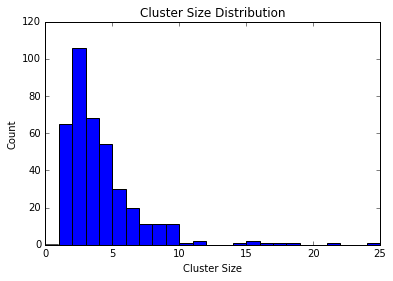

In [49]:
plot_cluster_size()